In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
def I_x(im, i, j):
    return -im[i-1,j-1] + im[i-1,j+1] - 2*im[i,j-1] + 2*im[i,j+1] - im[i+1,j-1] + im[i+1,j+1]

In [3]:
def I_y(im, i, j):
    return im[i-1,j-1] + im[i-1,j+1] - 2*im[i+1,j] + 2*im[i-1,j] - im[i+1,j-1] - im[i+1,j+1]

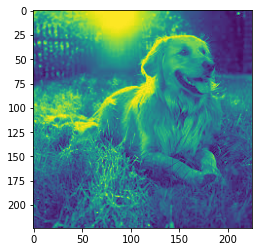

In [4]:
img = cv2.imread('E:\Dataset\dog.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(img)

In [5]:
X = np.zeros((img.shape[0]+2, img.shape[1]+2))
Y = np.zeros((img.shape[0]+2, img.shape[1]+2))

for i in range(1,img.shape[0]-1):
    for j in range(1,img.shape[1]-1):
        X[i-1,j-1] = I_x(img,i,j)

for i in range(1,img.shape[0]-1):
    for j in range(1,img.shape[1]-1):
        Y[i-1,j-1] = I_y(img,i,j)

C:\Users\Pradip\AppData\Local\Temp\ipykernel_16608\1691893526.py:2: RuntimeWarning: overflow encountered in ubyte_scalars
  return -im[i-1,j-1] + im[i-1,j+1] - 2*im[i,j-1] + 2*im[i,j+1] - im[i+1,j-1] + im[i+1,j+1]


In [6]:
M = (X*X + Y*Y)**(1/2)

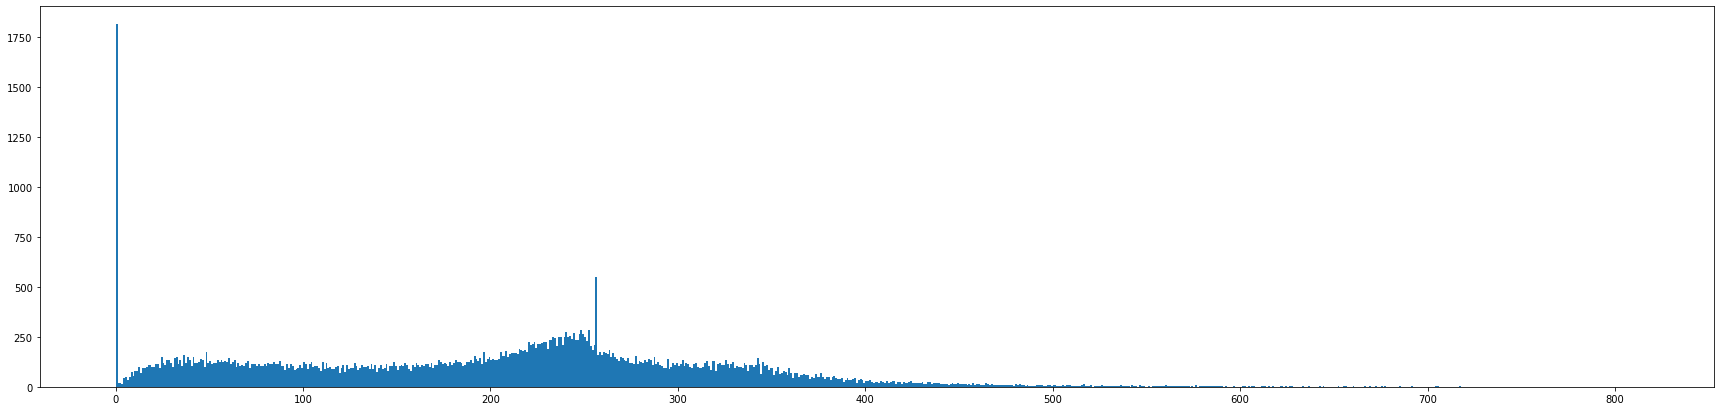

In [7]:
fig, ax = plt.subplots(figsize =(30, 7))
a,b,c= ax.hist(M.reshape(M.shape[0]*M.shape[1]), bins = [i for i in range(1+int(M.max()))])

In [8]:
k = 0
I = 0
for i in range(a.shape[0]):
    k += a[i]
    if k/a.sum() >= 0.5:
        I = i+1
        break
I

215

In [9]:
def g(x,B):
    return np.exp(-(x/B)**2)

def pixel(im, i, j, B, l=0.1):
    DN = im[i-1,j] - im[i,j]
    DS = im[i+1,j] - im[i,j]
    DE = im[i,j+1] - im[i,j]
    DW = im[i,j-1] - im[i,j] 

    cN = g(DN, B)
    cS = g(DS, B)
    cE = g(DE, B)
    cW = g(DW, B)

    return im[i,j] + l*(cN*DN + cS*DS + cE*DE + cW*DW)

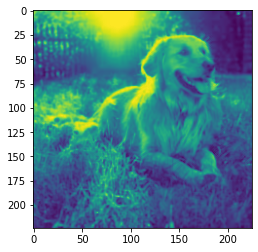

In [10]:
A = np.zeros((img.shape[0]+2, img.shape[1]+2))

for i in range(1,A.shape[0]-1):
    for j in range(1,A.shape[1]-1):
        A[i,j] = img[i-1,j-1]

A2 = np.zeros(img.shape)

for i in range(1,A.shape[0]-1):
    for j in range(1,A.shape[1]-1):
        A2[i-1,j-1] = pixel(A, i, j, I, l=0.2)
plt.imshow(A2)